In [1]:
import pandas as pd
import numpy as np
import sklearn

In [2]:
from sklearn.metrics import *
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import *
from sklearn.model_selection import train_test_split
import smogn

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [33]:
seed = 8

In [5]:
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score, mean_squared_log_error
def evaluate(y_pred, y_test):
    """ Prints out the evaluation metrics of the experiment
        parameters:
            y_pred
                DataFrame or array-like, the predictions
            y_test
                DataFrame or array-like, the actual y-values
                
            these two parameters must have the same dimensions
    """
    print("r^2: ", r2_score(y_test, y_pred))
    print("mse: ", mean_squared_error(y_test, y_pred))
    print("variance_score: ", explained_variance_score(y_test, y_pred))
    print("mse-log: ", mean_squared_log_error(y_test, y_pred))

In [6]:
def run(model, model_name, x_train, x_val):
    """ Fits the model and prints out results from calling evaluate on the training and validation set
        parameters:
            model
                the unfitted model, from sklearn (has to have a fit and predict method)
            model_name
                String, the name of the model
            x_train
                DataFrame, the training set
            x_val
                DataFrame, the validation set
                
        returns:
            nothing
        
    """
    model = model.fit(x_train, y_train)
    y_pred = np.clip(model.predict(x_train), 0, 1000) # since negative results are meaningless
    
    print("[{0}] These are the results for the training set.".format(model_name))
    
    evaluate(y_pred, y_train)
    print("--------------------------------------")
    
    print("[{0}] These are the results for the validation set.".format(model_name))
    y_pred = np.clip(model.predict(x_val), 0, 1000) # since negative results are meaningless
    
    evaluate(y_pred, y_val)
    
    print("_____________________________________________")

In [53]:
df = pd.read_excel("../spring21_data/fa_stats_v3.xlsx")
df = df[df['poss'] >= 500]
injury = pd.read_excel("../spring21_data/season_ending_injury.xlsx")
injury_fa = df.merge(right=injury, how='inner', left_on=['clean_season', 'Player'], right_on=['clean_season', 'Player']).rename(columns={'Unnamed: 0': 'index'})
df = df[~df['Unnamed: 0'].isin(injury_fa['index'])]
df = df.select_dtypes(exclude=['object'])
df.drop(columns=["Unnamed: 0", "Minutes", "salary", "clean_season", "age", "end season_y", "season_end"], inplace=True)

X = df.drop(columns=["cap_space_usage"])
y = df["cap_space_usage"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=seed)
both = pd.concat([X_train, y_train], axis=1).reset_index().drop(columns=["index"])
smote_data_high = smogn.smoter(data = both,
                           y = 'cap_space_usage',
                           rel_xtrm_type = 'high',
                           rel_thres = 0.85,
                           k = 11,
                           drop_na_col = True,       ## boolean (True or False)
                           drop_na_row = True,
                           samp_method = 'balance')
smote_data_mid = smogn.smoter(data = both,
                           y = 'cap_space_usage',
                           rel_xtrm_type = 'both',
                           rel_thres = 0.2,
                           k = 11,
                           drop_na_col = True,       ## boolean (True or False)
                           drop_na_row = True,
                           samp_method = 'balance')
smote_data_low = smogn.smoter(data = both,
                           y = 'cap_space_usage',
                           rel_xtrm_type = 'both',
                           rel_thres = 0.01,
                           k = 11,
                           drop_na_col = True,       ## boolean (True or False)
                           drop_na_row = True,
                           samp_method = 'extreme')
smote_data = pd.concat([smote_data_high, smote_data_mid, smote_data_low], ignore_index=True).drop_duplicates()
sm = smote_data.sample(frac=1)
y = sm[['cap_space_usage']]
X = sm.drop(columns=['cap_space_usage'])

r_index: 100%|##########| 50/50 [00:00<00:00, 370.43it/s]


In [54]:
X.to_excel('X.xlsx')
y.to_excel('y.xlsx')
X_test.to_excel('X_test.xlsx')
y_test.to_excel('y_test.xlsx')

<AxesSubplot:>

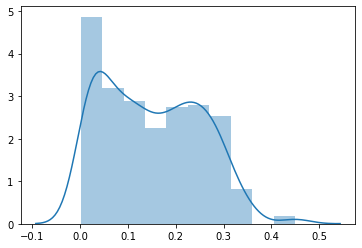

In [55]:
sns.distplot(y)

In [56]:
X.shape

(494, 66)

In [57]:
from sklearn.feature_selection import SelectKBest, f_regression
select = SelectKBest(f_regression, k=40)

best_features = select.fit_transform(X, y)
feature_scores = pd.concat([pd.Series(X.columns), pd.Series(select.scores_)], axis=1)
feature_scores.columns = ["features", "score"]
features = list(feature_scores.sort_values(by=["score"], ascending=False).head(25)['features'])

X = X[features]
feature_scores.sort_values(by=["score"], ascending=False).head(20)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.15, random_state=seed)

X_train = X_train[features]
X_test = X_test[features]
X_val = X_val[features]

In [58]:
params = {'n_estimators': 1268,
 'min_samples_split': 6,
 'min_samples_leaf': 5,
 'max_features': 'log2',
 'max_depth': None,
 'learning_rate': 0.025000000000000015,
 'alpha': 0.5500000000000002,
 'subsample': 0.95,
 'loss': 'quantile'}
model_gbr = GradientBoostingRegressor(**params)
model_gbr.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.5500000000000002,
                          learning_rate=0.025000000000000015, loss='quantile',
                          max_depth=None, max_features='log2',
                          min_samples_leaf=5, min_samples_split=6,
                          n_estimators=1268, subsample=0.95)

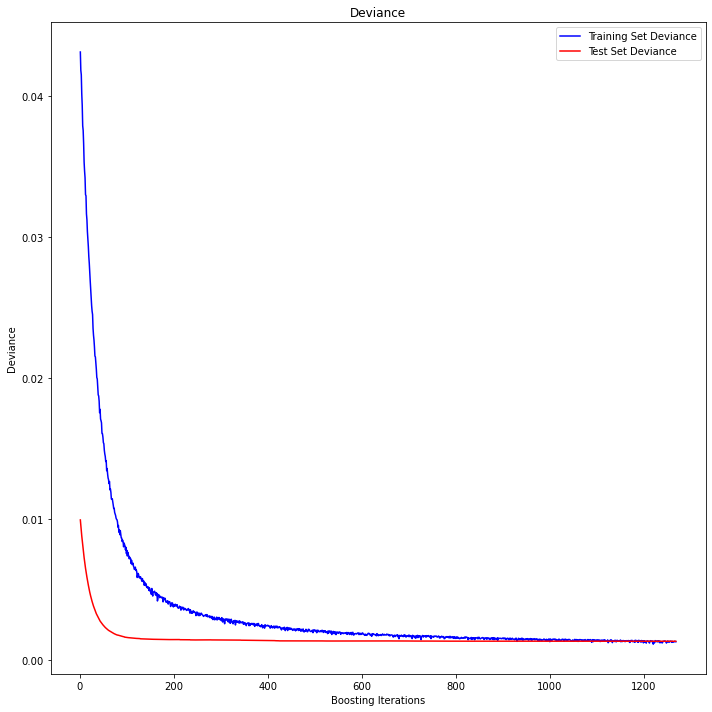

In [59]:
test_score = np.zeros((params['n_estimators'],), dtype=np.float64)
for i, y_pred in enumerate(model_gbr.staged_predict(X_val)):
    test_score[i] = mean_squared_error(y_val, y_pred)

fig = plt.figure(figsize=(10, 10))
plt.subplot(1, 1, 1)
plt.title('Deviance')
plt.plot(np.arange(params['n_estimators']) + 1, model_gbr.train_score_, 'b-',
         label='Training Set Deviance')
plt.plot(np.arange(params['n_estimators']) + 1, test_score, 'r-',
         label='Test Set Deviance')
plt.legend(loc='upper right')
plt.xlabel('Boosting Iterations')
plt.ylabel('Deviance')
fig.tight_layout()
plt.show()

In [60]:
evaluate(model_gbr.predict(X_test), y_test)

r^2:  0.874999124501328
mse:  0.0009886535424394613
variance_score:  0.875142358625036
mse-log:  0.0007880432374028542


In [390]:
from sklearn.model_selection import *
# Number of boosting iterations
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1000, num = 30)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt', 'log2']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.arange(3, 10)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [i for i in range(3, 13)]
# Minimum number of samples required at each leaf node
min_samples_leaf = [i for i in range(3, 13)]
alphas = [x for x in np.arange(0.05, 0.95, 0.1)]
loss = ['ls', 'lad', 'huber']
learning_rates = [x for x in np.arange(0.05, 0.001, -0.005)]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
              'learning_rate': learning_rates,
               'alpha': alphas}

In [391]:
gbdt_random = RandomizedSearchCV(estimator = GradientBoostingRegressor(loss='quantile'), param_distributions = random_grid, n_iter = 500, cv = 7, verbose=2, random_state=seed, n_jobs = -1)
gbdt_random.fit(X_train, y_train)

Fitting 7 folds for each of 500 candidates, totalling 3500 fits


RandomizedSearchCV(cv=7, estimator=GradientBoostingRegressor(loss='quantile'),
                   n_iter=500, n_jobs=-1,
                   param_distributions={'alpha': [0.05, 0.15000000000000002,
                                                  0.25000000000000006,
                                                  0.35000000000000003,
                                                  0.45000000000000007,
                                                  0.5500000000000002,
                                                  0.6500000000000001,
                                                  0.7500000000000002,
                                                  0.8500000000000002],
                                        'learning_rate': [0.05,
                                                          0.045000000000000005,
                                                          0.040000000000000...
                                                          0.010000000000000023,
     

In [41]:
gbdt_random.best_params_

NameError: name 'gbdt_random' is not defined

In [61]:
params = {'n_estimators': 688,
 'min_samples_split': 6,
 'min_samples_leaf': 5,
 'max_features': 'log2',
 'max_depth': None,
 'learning_rate': 0.025000000000000015,
 'alpha': 0.5500000000000002,
 'subsample': 0.95,
 'loss': 'quantile'}
model_gbr = GradientBoostingRegressor(**params)

In [62]:
run(model_gbr, "Gradient Boost Decision Tree", X_train, X_val)

[Gradient Boost Decision Tree] These are the results for the training set.
r^2:  0.9866239906133963
mse:  0.00013904515136483928
variance_score:  0.9866448290105595
mse-log:  9.703017502753741e-05
--------------------------------------
[Gradient Boost Decision Tree] These are the results for the validation set.
r^2:  0.8718479063495869
mse:  0.0013132678973498423
variance_score:  0.8723433178798092
mse-log:  0.0009895569139304812
_____________________________________________


In [64]:
evaluate(model_gbr.predict(X_test), y_test)

r^2:  0.8740627513911914
mse:  0.000996059479307411
variance_score:  0.8750936606514121
mse-log:  0.0008016984706875554


## Sanity Check

In [45]:
data = pd.read_excel("../spring21_data/fa_stats_v3.xlsx")

In [46]:
test_index = X_test.index

In [47]:
test_data = data.iloc[test_index][['clean_season','Player','MPG', 'attempted_field_goals', 'minutes_played', 'WS', 'Wins Added', 'poss','cap_space_usage']]

In [48]:
results = pd.concat([test_data, pd.DataFrame(index=test_index, data=model_gbr.predict(X_test))], axis=1)

In [49]:
results

,clean_season,Player,MPG,attempted_field_goals,minutes_played,WS,Wins Added,poss,cap_space_usage,0
377,2019,Dragan Bender,18.0,4.282609,17.956522,0.5,0.797767,1778,0.015383,0.027295
105,2016,Wayne Ellington,21.3,7.381579,21.250000,0.8,-1.193968,3266,0.063733,0.031982
60,2016,Dewayne Dedmon,12.2,3.051724,12.155172,2.4,1.009431,1434,0.030783,0.029940
0,2016,Kevin Durant,35.8,19.180556,35.805556,14.5,12.406201,6806,0.281913,0.303823
285,2019,Kawhi Leonard,34.0,18.816667,34.000000,9.5,8.845318,6150,0.300000,0.289610
283,2018,Avery Bradley,31.2,14.250000,31.700000,-0.2,0.433693,2918,0.117798,0.101742
179,2017,Michael Beasley,16.7,7.250000,16.696429,1.8,0.622438,1991,0.014848,0.061545
126,2017,Andre Iguodala,26.3,5.460526,26.289474,6.9,5.790783,5120,0.149504,0.137943
327,2019,Tyus Jones,22.9,6.558824,22.941176,3.0,3.210259,3329,0.077039,0.066152
86,2016,Terrence Jones,20.9,7.340000,20.880000,1.5,-0.660942,2167,0.011163,0.047199
